## Goal: The owner of an online shop wants to increase revenues. In particular, the owner is interested in making accurate predictions on whether her online customer will end up purchasing products.

In [1]:
import numpy as np 
import pandas as pd 
import io
from scipy import stats
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline  
import seaborn as sns

In [2]:
train_df = pd.read_csv("online_shop_train.csv")
test_df = pd.read_csv("online_shop_test_final.csv")

### First, let's take a look at how the data looks like.

In [3]:
train_df.head()

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,3935,1.0,50.333333,0.0,0.0,21.0,586.189286,0.000000,0.005556,0.0,0.6,May,1,1,1,2,Returning_Visitor,0,0
1,7866,6.0,299.000000,1.0,41.0,36.0,696.402778,0.000000,0.002632,0.0,0.0,May,2,2,2,4,New_Visitor,1,0
2,3727,0.0,0.000000,0.0,0.0,19.0,620.033333,0.000000,0.007895,0.0,0.0,Feb,1,1,4,2,Returning_Visitor,0,0
3,4454,0.0,0.000000,0.0,0.0,4.0,46.250000,0.050000,0.066667,0.0,0.0,Nov,3,2,6,13,Returning_Visitor,0,0
4,6186,0.0,0.000000,0.0,0.0,24.0,671.088653,0.026667,0.036566,0.0,0.0,Nov,1,1,3,2,Returning_Visitor,0,0


In [4]:
train_df.describe()

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue
count,8630.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8622.000000,8630.000000,8630.000000,8630.000000,8630.000000,8630.000000,8630.000000,8630.00000,8630.000000
mean,8015.500000,2.343192,83.405240,0.490373,33.159578,31.872419,1192.184366,0.021920,0.042457,5.699051,0.061738,2.123986,2.349594,3.153418,4.115064,0.23372,0.154693
std,2491.410745,3.315094,182.985925,1.258803,138.432097,44.605549,1944.264408,0.047651,0.047784,17.769196,0.199358,0.914171,1.718458,2.408576,4.069918,0.42322,0.361633
min,3701.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000
25%,5858.250000,0.000000,0.000000,0.000000,0.000000,7.000000,192.462500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,0.00000,0.000000
50%,8015.500000,1.000000,9.000000,0.000000,0.000000,18.000000,606.283333,0.003279,0.025000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,0.00000,0.000000
75%,10172.750000,4.000000,95.575000,0.000000,0.000000,37.000000,1450.841355,0.017497,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000,0.00000,0.000000
max,12330.000000,26.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,360.953384,1.000000,8.000000,13.000000,9.000000,20.000000,1.00000,1.000000


### Excluding ID and Revenue, there are 10 numerical features and  7 categorical features in train_df.

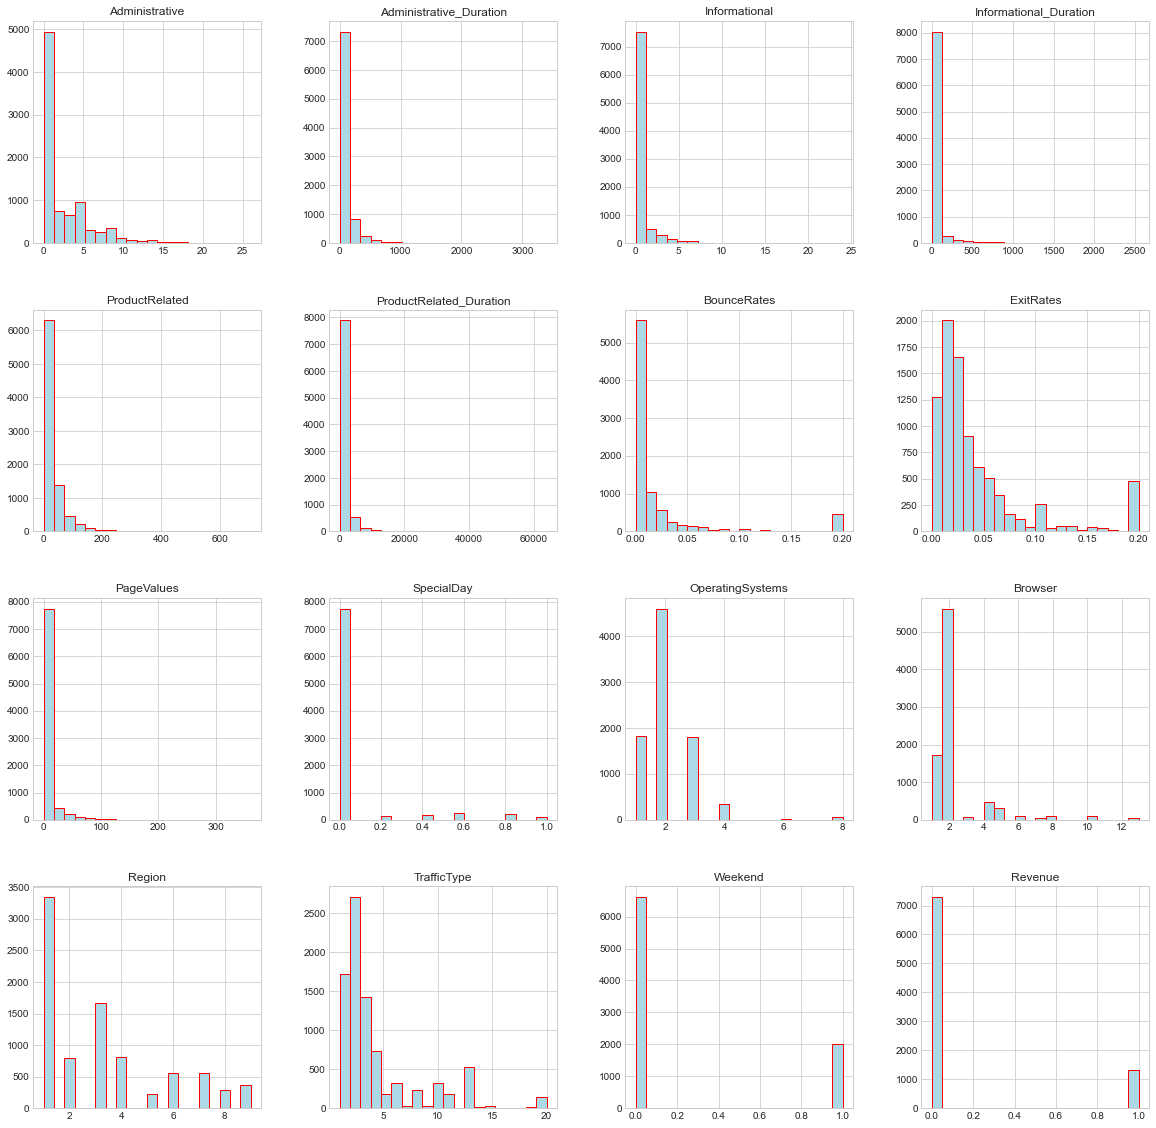

In [5]:
plt.style.use('seaborn-whitegrid')

train_df.iloc[:,1:].hist(bins=20, figsize=(20,20), color='lightblue', edgecolor = 'red')
plt.show()

<AxesSubplot:>

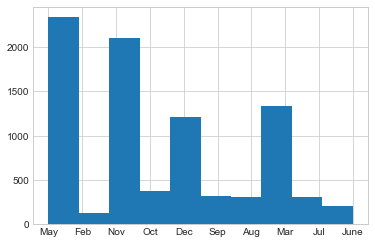

In [6]:
train_df['Month'].hist()

<AxesSubplot:>

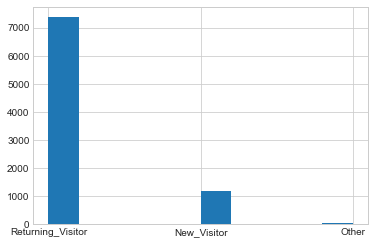

In [7]:
train_df['VisitorType'].hist()

### We can see that many customers are returning visitors. They did not spend a lot of time in administrative, Informational and product related pages. While browsing in the store, many customers have low bounce and exit rates with high page values.  Majority of the customers are from Region 1 and did not shop on special days and weekends. It's also noticeable that the most visited months are May and November.

### Let's take a look correlations between Revenue and numerical features.

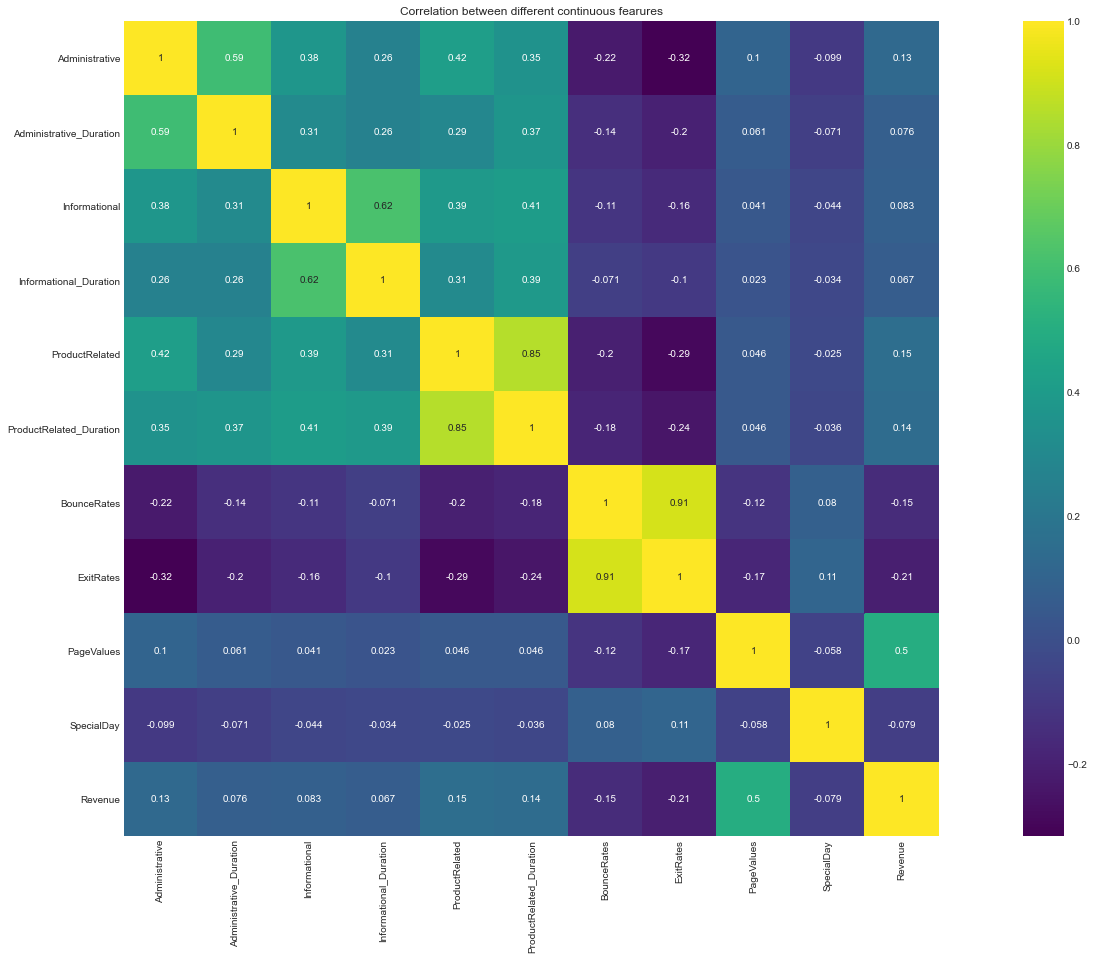

In [8]:
def correlation_heatmap(dataframe,l,w):
    corr = dataframe.corr()
    
    plt.figure(figsize=(l,w))
    sns.heatmap(corr, vmax=1, square=True,annot=True,cmap='viridis')
    
    plt.title('Correlation between different continuous fearures')
    plt.show();
    
cleandf = train_df.iloc[:,1:]
cleandf = cleandf[['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration',\
                   'BounceRates','ExitRates','PageValues','SpecialDay','Revenue']]
correlation_heatmap(cleandf, 30,15)

### Only PageValues and Revenue have a noticeable correlation.

### Now, It would be good to know how many customers generate revenue out of total 8630 customers in train_df.

In [9]:
 train_w_revenue_df = train_df[train_df.Revenue == 1]
 train_w_revenue_df

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
10,4641,3.0,224.300000,5.0,487.00,74.0,1845.958333,0.002532,0.017679,34.678415,0.0,Nov,2,2,1,10,Returning_Visitor,1,1
13,4443,11.0,631.416667,5.0,1037.15,501.0,21672.244250,0.003965,0.014292,9.131387,0.0,Nov,2,2,1,2,Returning_Visitor,0,1
14,6435,4.0,218.966667,0.0,0.00,12.0,672.700000,0.000000,0.004444,83.101143,0.0,Nov,2,2,3,2,Returning_Visitor,1,1
15,5828,2.0,69.000000,2.0,92.00,37.0,796.957143,0.000000,0.024274,3.978276,0.0,Mar,2,2,7,2,Returning_Visitor,0,1
20,10988,1.0,29.200000,1.0,322.40,10.0,126.933333,0.014286,0.036905,13.594200,0.0,Sep,2,2,1,2,Returning_Visitor,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8607,5023,0.0,0.000000,0.0,0.00,31.0,1144.972222,0.006667,0.008333,77.041998,0.0,Dec,2,2,7,2,New_Visitor,0,1
8609,4628,7.0,421.250000,0.0,0.00,59.0,1945.896667,0.012240,0.010579,28.529190,0.0,June,2,6,1,20,Returning_Visitor,0,1
8613,4852,0.0,0.000000,0.0,0.00,50.0,1803.768849,0.001361,0.017428,3.609399,0.0,Mar,2,4,7,3,Returning_Visitor,1,1
8623,6453,3.0,275.000000,1.0,29.50,30.0,1107.047619,0.000000,0.017761,35.981066,0.0,Mar,3,2,3,1,Returning_Visitor,1,1


### Only 1335 customers generate revenue. Thus, the data is highly imbalanced. Let's take a look at distributions of the data. 

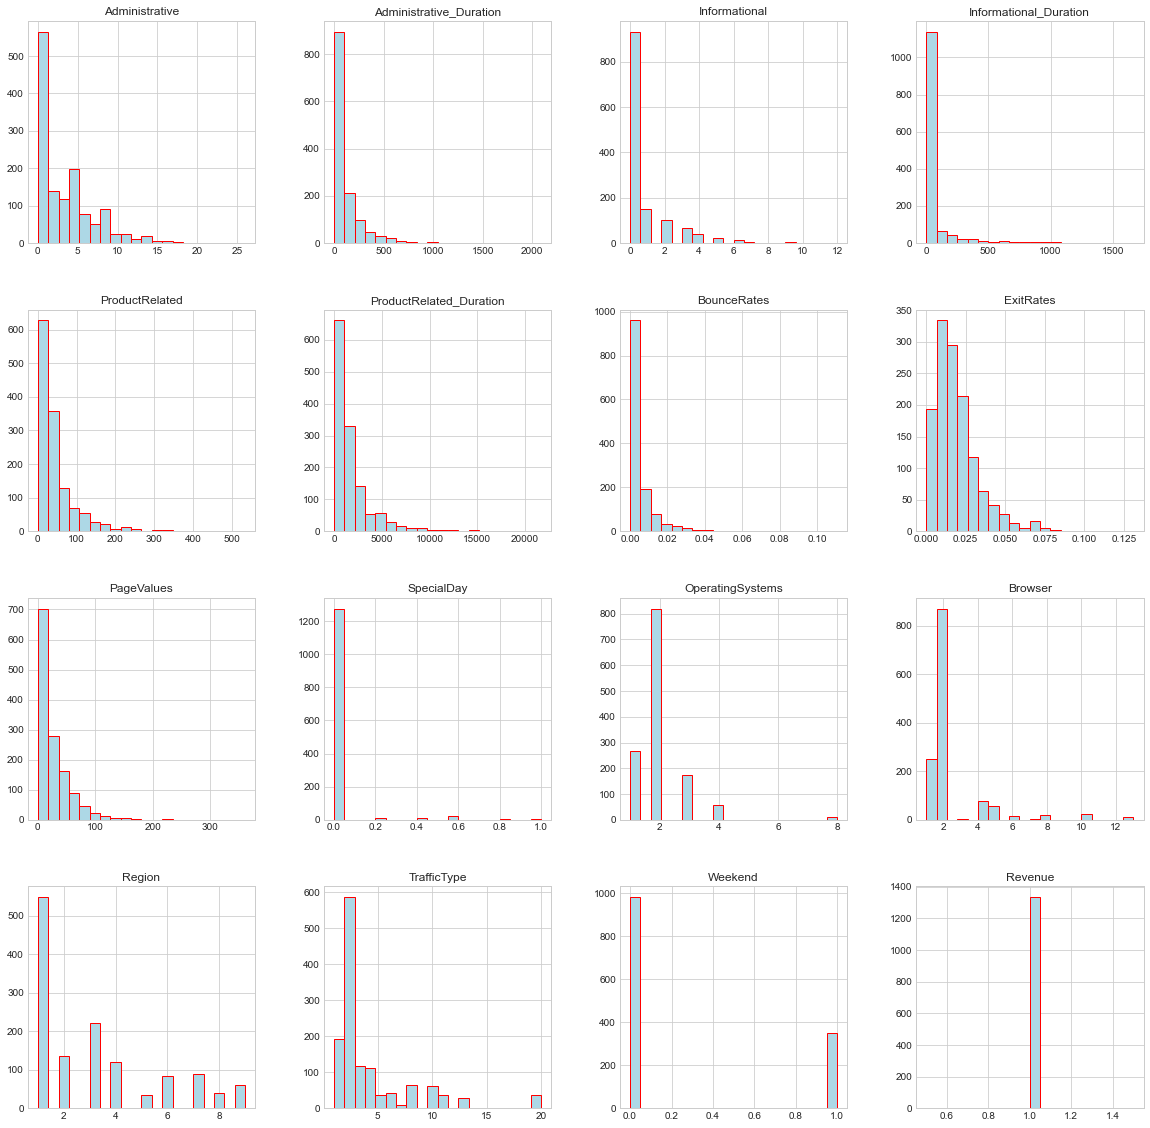

In [10]:
plt.style.use('seaborn-whitegrid')

train_w_revenue_df.iloc[:,1:].hist(bins=20, figsize=(20,20), color='lightblue', edgecolor = 'red')
plt.show()

<AxesSubplot:>

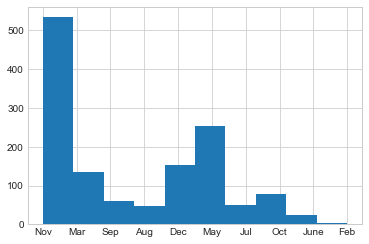

In [11]:
train_w_revenue_df['Month'].hist()

<AxesSubplot:>

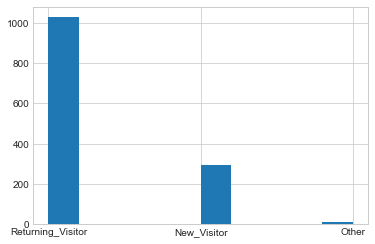

In [12]:
train_w_revenue_df['VisitorType'].hist()

### We can see that distributions of the customers data with revenue are similar to the distributions of all customers data plotted in the above cells. Nonetheless, there were slight changes. The most visted month is now November instead of March and November. Since Black Friday is in November, it may have contributed to the sales of the store.  

### Now, before we build a prediction model, let's pre-process data.

### First, check missing values.

In [13]:
train_df.info()
train_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8630 entries, 0 to 8629
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       8630 non-null   int64  
 1   Administrative           8622 non-null   float64
 2   Administrative_Duration  8622 non-null   float64
 3   Informational            8622 non-null   float64
 4   Informational_Duration   8622 non-null   float64
 5   ProductRelated           8622 non-null   float64
 6   ProductRelated_Duration  8622 non-null   float64
 7   BounceRates              8622 non-null   float64
 8   ExitRates                8622 non-null   float64
 9   PageValues               8630 non-null   float64
 10  SpecialDay               8630 non-null   float64
 11  Month                    8630 non-null   object 
 12  OperatingSystems         8630 non-null   int64  
 13  Browser                  8630 non-null   int64  
 14  Region                  

(8630, 19)

In [14]:
test_df.info()
test_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       3700 non-null   int64  
 1   Administrative           3694 non-null   float64
 2   Administrative_Duration  3694 non-null   float64
 3   Informational            3694 non-null   float64
 4   Informational_Duration   3694 non-null   float64
 5   ProductRelated           3694 non-null   float64
 6   ProductRelated_Duration  3694 non-null   float64
 7   BounceRates              3694 non-null   float64
 8   ExitRates                3694 non-null   float64
 9   PageValues               3700 non-null   float64
 10  SpecialDay               3700 non-null   float64
 11  Month                    3700 non-null   object 
 12  OperatingSystems         3700 non-null   int64  
 13  Browser                  3700 non-null   int64  
 14  Region                  

(3700, 18)

In [15]:
train_df.isnull().any(axis = 1).sum()

8

In [16]:
test_df.isnull().any(axis = 1).sum()

6

### train_df has 8 rows with missing values and test_df has 6 rows with missing values.

In [17]:
train_w_revenue_df.isnull().sum()

ID                         0
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

### Fortunately, there is no missing values with customers that generate revenue. 

### Before we move on, check 8 rows with missing values in train_df to see if there is any noticeable pattern.

In [18]:
null_data = train_df[train_df.isnull().any(axis=1)]
null_data

,ID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
502,3934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,0,0
1597,7032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,3,1,Returning_Visitor,0,0
1974,5695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,1,2,Returning_Visitor,0,0
3801,8387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,3,2,1,1,Returning_Visitor,0,0
3833,7446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,4,5,1,Returning_Visitor,0,0
4270,5563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,1,Returning_Visitor,1,0
6665,12293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,2,1,Returning_Visitor,0,0
8252,10419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,0,0


### We can notice that all rows with the missing data occured from returning visitors who visited the store in March. 

### Since missing values are all numerical features, let's impute with median.

In [19]:
train_df['Administrative'] = train_df['Administrative'].fillna(train_df['Administrative'].median())
train_df['Administrative_Duration'] = train_df['Administrative_Duration'].fillna(train_df['Administrative_Duration'].median())

train_df['Informational'] = train_df['Informational'].fillna(train_df['Informational'].median())
train_df['Informational_Duration'] = train_df['Informational_Duration'].fillna(train_df['Informational_Duration'].median())

train_df['ProductRelated'] = train_df['ProductRelated'].fillna(train_df['ProductRelated'].median())
train_df['ProductRelated_Duration'] = train_df['ProductRelated_Duration'].fillna(train_df['ProductRelated_Duration'].median())

train_df['BounceRates'] = train_df['BounceRates'].fillna(train_df['BounceRates'].median())
train_df['ExitRates'] = train_df['ExitRates'].fillna(train_df['ExitRates'].median())

In [20]:
train_df.isnull().sum()

ID                         0
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

### Now, create dummy variables for categorical variables in train_df and test_df.

In [21]:
train_df = pd.get_dummies(train_df, columns=['Month'])
train_df = pd.get_dummies(train_df, columns=['OperatingSystems'])
train_df = pd.get_dummies(train_df, columns=['Region'])
train_df = pd.get_dummies(train_df, columns=['VisitorType'])
train_df = pd.get_dummies(train_df, columns=['Weekend'])

### Let's do the same thing for test_df.

In [22]:
test_df = pd.get_dummies(test_df, columns=['Month'])
test_df = pd.get_dummies(test_df, columns=['OperatingSystems'])
test_df = pd.get_dummies(test_df, columns=['Region'])
test_df = pd.get_dummies(test_df, columns=['VisitorType'])
test_df = pd.get_dummies(test_df, columns=['Weekend'])

### Remove ID and Revenue from X DataFrame before we train models.

In [23]:
# delete ID
feature_names = train_df.columns.values[1:]

# delete revenue
revenue_index = np.argwhere(feature_names == 'Revenue')
feature_names = np.delete(feature_names, revenue_index)
feature_names

array(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'BounceRates', 'ExitRates',
       'PageValues', 'SpecialDay', 'Browser', 'TrafficType', 'Month_Aug',
       'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
       'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3',
       'OperatingSystems_4', 'OperatingSystems_5', 'OperatingSystems_6',
       'OperatingSystems_7', 'OperatingSystems_8', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7',
       'Region_8', 'Region_9', 'VisitorType_New_Visitor',
       'VisitorType_Other', 'VisitorType_Returning_Visitor', 'Weekend_0',
       'Weekend_1'], dtype=object)

In [24]:
X = train_df[feature_names]

In [25]:
Y = train_df[['Revenue']]

### Now, let's create XGBoost model.

In [26]:
clf_xgb = XGBClassifier(objective = 'binary:logistic')

param_dist = {'n_estimators': [100],
              'subsample': [0.7,0.8,0.9],
              'max_depth': [3, 4, 6, 8],
              'colsample_bytree': [0.7,0.8,0.9],
              'min_child_weight': [1,2,3,4],
              'gamma': [1,3,5],
              'eta': [0.0001,0.001,0.1]
             }


clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 100, scoring = 'roc_auc', error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 10
folds = KFold(n_splits = numFolds, shuffle = True)
print(folds)

estimators = []
results = np.zeros(len(X))
score = 0.0
for train_index, val_index in folds.split(X):
    print("new fold")
    X_train, X_val = X.iloc[train_index,:], X.iloc[val_index,:]
    y_train, y_val = Y.iloc[train_index].values.ravel(), Y.iloc[val_index].values.ravel()
    print("fitting")
    clf.fit(X_train, y_train)

    estimators.append(clf.best_estimator_)
    print(clf.best_estimator_)
    results[val_index] = clf.predict(X_val)
    auc_score = roc_auc_score(y_val, results[val_index])
    score += auc_score
    print("score",auc_score)
score /= numFolds

KFold(n_splits=10, random_state=None, shuffle=True)
new fold
fitting
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished


XGBClassifier(colsample_bytree=0.9, eta=0.001, gamma=5, subsample=0.9)
score 0.7941606810321894
new fold
fitting
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished


XGBClassifier(colsample_bytree=0.8, eta=0.0001, gamma=5, max_depth=4,
              subsample=0.9)
score 0.790292732166891
new fold
fitting
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished


XGBClassifier(colsample_bytree=0.8, eta=0.001, gamma=5, max_depth=4,
              subsample=0.8)
score 0.7986656671664168
new fold
fitting
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished


XGBClassifier(colsample_bytree=0.8, eta=0.0001, gamma=5, max_depth=4,
              min_child_weight=4, subsample=0.9)
score 0.7725880466017687
new fold
fitting
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished


XGBClassifier(colsample_bytree=0.7, eta=0.1, gamma=5, max_depth=6,
              subsample=0.9)
score 0.7759919525089767
new fold
fitting
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished


XGBClassifier(colsample_bytree=0.8, eta=0.1, gamma=5, max_depth=6,
              min_child_weight=2, subsample=0.9)
score 0.7430383346604482
new fold
fitting
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished


XGBClassifier(colsample_bytree=0.7, eta=0.1, gamma=3, max_depth=4,
              min_child_weight=2, subsample=0.9)
score 0.7507251153592617
new fold
fitting
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


XGBClassifier(colsample_bytree=0.7, eta=0.0001, gamma=3, max_depth=4,
              min_child_weight=3, subsample=0.9)
score 0.7959540732640787
new fold
fitting
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


XGBClassifier(colsample_bytree=0.8, eta=0.001, gamma=5, min_child_weight=3,
              subsample=0.9)
score 0.7797744890768146
new fold
fitting
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished


XGBClassifier(colsample_bytree=0.7, eta=0.001, gamma=3, min_child_weight=4,
              subsample=0.9)
score 0.7895095813872278


### Let's pick the best model with the highest AUC.

In [27]:
model = estimators[2]

In [28]:
model

XGBClassifier(colsample_bytree=0.8, eta=0.001, gamma=5, max_depth=4,
              subsample=0.8)

### Before we make predictions on test set data, let's plot feature importance.

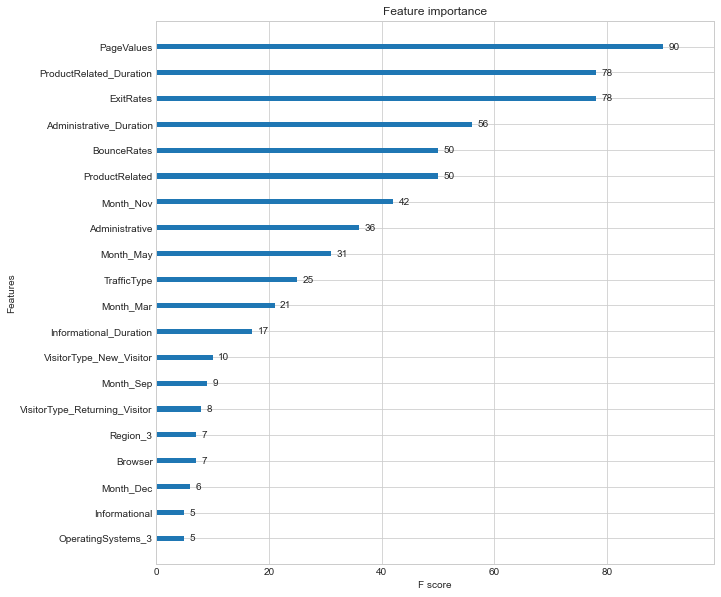

In [29]:
ax = xgboost.plot_importance(model, max_num_features=20)
fig = ax.figure
fig.set_size_inches(10, 10)

### We can see that feature such as PageValues, ProductRelated_Duration, ExitRate, Administrative_Duration, BounceRates and ProdutRelated are important features.

### Now, make predictions with test_df (test set data).

In [30]:
feature_names = list(X.columns)
pred = model.predict(test_df[feature_names])

In [31]:
unique, counts = np.unique(pred, return_counts=True)
dict(zip(unique, counts))

{0: 3222, 1: 478}

In [32]:
pred = model.predict_proba(test_df[feature_names])[:,1]

In [33]:
submission = pd.DataFrame({'ID':test_df['ID'],'Revenue':pred})

submission.head(20)

,ID,Revenue
0,2762,0.029074
1,308,0.611640
2,1018,0.006967
3,426,0.001786
4,2754,0.010653
5,1663,0.003822
6,3473,0.003352
7,2060,0.027945
8,2445,0.002819
9,882,0.008772


In [34]:
filename = 'Predictions24.csv'

submission.to_csv(filename,index=False)


print('Saved file: ' + filename)

Saved file: Predictions24.csv
